<span style="display:block;text-align:center;margin-right:105px"><img src="../media/logos/hacks-logo.png" width="200"/></span>

## Table of Contents

<ul>
    <li><a href='#Dependencies'>Dependencies</a></li>
        <li><a href='#Setup-/-Preparatory-Steps'>Setup / Preparatory Steps</a>
                   <ul style='margin-top: 0em;'>
            <li><a href='#Generate-ranges-of-parameters-using-the-sweep_cartesian_product-method'>Generate ranges of parameters using the sweep_cartesian_product method</a></li>
        </ul>
    </li>
    <li><a href='#Modelling'>Modelling</a>
        <ol style='margin-top: 0em;'>
            <li><a href='#1.-State-Variables'>State Variables</a></li>
            <li><a href='#2.-System-Parameters'>System Parameters</a></li>
            <li><a href='#3.-Policy-Functions'>Policy Functions</a></li>
            <li><a href='#4.-State-Update-Functions'>State Update Functions</a></li>
            <li><a href='#5.-Partial-State-Update-Blocks'>Partial State Update Blocks</a></li>
        </ol>
    </li>
    <li><a href='#Simulation'>Simulation</a>
        <ol style='margin-top: 0em;' start="6">
            <li><a href='#6.-Configuration'>Configuration</a></li>
            <li><a href='#7.-Execution'>Execution</a></li>
            <li><a href='#8.-Output-Preparation'>Output Preparation</a></li>
            <li><a href='#9.-Analysis'>Analysis</a></li>
        </ol>
    </li>
</ul>

---

# Dependencies

In [1]:
# cadCAD standard dependencies

# cadCAD configuration modules
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment

# cadCAD simulation engine modules
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor

# cadCAD global simulation configuration list
from cadCAD import configs

# Included with cadCAD
import pandas as pd

In [2]:
# Additional dependencies

# sweep_cartesian_product makes it easy to create large-scale simulations
from cadcad_machine_search.tools import sweep_cartesian_product

# For analytics
import numpy as np
# For visualization
import plotly.express as px

# Setup / Preparatory Steps

## Generate ranges of parameters using the `sweep_cartesian_product` method

In [3]:
PARAMS_TO_SWEEP = {
    # Parameters describing the interaction between the two populations:

    # A parameter used to calculate the rate of predator death
    # Generate 3 distinct values between 0.2 and 1.2
    "predator_death_parameter": np.linspace(0.2, 1.2, 3),

    # A parameter used to calculate the rate of prey death
    # Generate 3 distinct values between 0.0 and 0.06
    "prey_death_parameter": np.linspace(0, 0.06, 3),

    # Parameter used as conversion factor between 1 unit of time and 1 timestep
    # 10 timesteps == 1 unit of time, i.e. every 10 cadCAD model timesteps, 1 unit of actual model time passes

    # Generate 2 distinct values between 0.02 and 0.1
    "dt": np.linspace(0.02, 0.1, 2)
}

# Create a dictionary with the cartesian product
sweep_params = sweep_cartesian_product(PARAMS_TO_SWEEP)

# Our new system parameters
params = {
    # Parameters describing the interaction between the two populations:

    # A parameter used to calculate the rate of predator birth
    "predator_birth_parameter": [0.01],

    # A parameter used to calculate the rate of prey birth
    "prey_birth_parameter": [1.0],

    # Parameters used for random Numpy variable tuning
    # These parameters scale the random variable used to create the random birth / death rate

    "random_predator_birth": [0.0002],
    "random_predator_death": [0.005],
    "random_prey_birth": [0.1],
    "random_prey_death": [0.1],

    **sweep_params
}

print(params['predator_death_parameter'])

[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2]


# Modelling

## 1. State Variables

In [4]:
initial_state = {
    'predator_population': 15, # Initial number of predators
    'prey_population': 100, # Initial number of preys
}
initial_state

{'predator_population': 15, 'prey_population': 100}

## 2. System Parameters

In [5]:
system_params = params

## 3. Policy Functions

In [6]:
def p_predator_births(params, substep, state_history, previous_state):
    '''Predator Births Policy Function
    The predator birth rate (rate of predators born per unit of time) is a product of
    the prey population and the predator birth parameter plus a random variable.
    
    i.e. the larger the prey population, the higher the predator birth rate
    '''
    # Parameters   
    dt = params['dt']
    predator_birth_parameter = params['predator_birth_parameter']
    random_predator_birth = params['random_predator_birth']

    # State Variables
    predator_population = previous_state['predator_population']
    prey_population = previous_state['prey_population']

    # Calculate the predator birth rate
    birth_rate = prey_population * (predator_birth_parameter + np.random.random() * random_predator_birth)
    # Calculate change in predator population
    births = birth_rate * predator_population * dt

    return {'add_to_predator_population': births}


def p_predator_deaths(params, substep, state_history, previous_state):
    '''Predator Deaths Policy Function
    The predator death rate (rate of predators that die per unit of time) is a function of
    the predator death parameter plus a random variable.
    
    i.e. the larger the predator death parameter, the higher the predator death rate
    '''
    # Parameters
    dt = params['dt']
    predator_death_parameter = params['predator_death_parameter']
    random_predator_death = params['random_predator_death']

    # State Variables
    predator_population = previous_state['predator_population']

    # Calculate the predator death rate
    death_rate = predator_death_parameter + np.random.random() * random_predator_death
    # Calculate change in predator population
    deaths = death_rate * predator_population * dt

    return {'add_to_predator_population': -1.0 * deaths}


def p_prey_births(params, substep, state_history, previous_state):
    '''Prey Births Policy Function
    The prey birth rate (rate of preys born per unit of time) is a function of
    the prey birth parameter plus a random variable.
    
    i.e. the larger the prey birth parameter, the higher the prey birth rate
    '''
    # Parameters
    dt = params['dt']
    prey_birth_parameter = params['prey_birth_parameter']
    random_prey_birth = params['random_prey_birth']

    # State Variables
    prey_population = previous_state['prey_population']

    # Calculate the prey birth rate
    birth_rate = prey_birth_parameter + np.random.random() * random_prey_birth
    # Calculate change in prey population
    births = birth_rate * prey_population * dt

    return {'add_to_prey_population': births}


def p_prey_deaths(params, substep, state_history, previous_state):
    '''Prey Deaths Policy Function
    The prey death rate (rate of preys that die per unit of time) is a product of
    the predator population and the prey death parameter plus a random variable.
    
    i.e. the larger the predator population, the higher the prey death rate
    '''
    # Parameters
    dt = params['dt']
    prey_death_parameter = params['prey_death_parameter']
    random_prey_death = params['random_prey_death']

    # State Variables
    prey_population = previous_state['prey_population']
    predator_population = previous_state['predator_population']

    # Calculate the prey death rate
    death_rate = predator_population * (prey_death_parameter + np.random.random() * random_prey_death)
    # Calculate change in prey population
    deaths = death_rate * prey_population * dt

    return {'add_to_prey_population': -1.0 * deaths}

## 4. State Update Functions

In [7]:
def s_predator_population(params, substep, state_history, previous_state, policy_input):
    '''Predator Population State Update Function
    Take the Policy Input `add_to_predator_population`
    (the net predator births and deaths)
    and add to the `predator_population` State Variable.
    '''
    # Policy Inputs
    add_to_predator_population = policy_input['add_to_predator_population']

    # State Variables
    predator_population = previous_state['predator_population']

    # Calculate updated predator population
    updated_predator_population = predator_population + add_to_predator_population

    return 'predator_population', updated_predator_population


def s_prey_population(params, substep, state_history, previous_state, policy_input):
    '''Prey Population State Update Function
    Take the Policy Input `add_to_prey_population`
    (the net prey births and deaths)
    and add to the `prey_population` State Variable.
    '''
    # Policy Inputs
    add_to_prey_population = policy_input['add_to_prey_population']

    # State Variables
    prey_population = previous_state['prey_population']

    # Calculate updated prey population
    updated_prey_population = prey_population + add_to_prey_population

    return 'prey_population', updated_prey_population

## 5. Partial State Update Blocks

In [8]:
partial_state_update_blocks = [
    {   
        # Configure the model Policy Functions
        'policies': {
            # Calculate the predator birth rate and number of births
            'predator_births': p_predator_births,
            # Calculate the predator death rate and number of deaths
            'predator_deaths': p_predator_deaths,
            # Calculate the prey birth rate and number of births
            'prey_births': p_prey_births,
            # Calculate the prey death rate and number of deaths
            'prey_deaths': p_prey_deaths,
        },
        # Configure the model State Update Functions
        'variables': {
            # Update the predator population
            'predator_population': s_prey_population,
            # Update the prey population
            'prey_population': s_predator_population
        }
    }
]

# Simulation

## 6. Configuration

In [9]:
sim_config = config_sim({
    "N": 5, # the number of times we'll run the simulation ("Monte Carlo runs")
    "T": range(300), # the number of timesteps the simulation will run for
    "M": system_params # the parameters of the system
})

In [10]:
del configs[:] # Clear any prior configs

In [11]:
experiment = Experiment()
experiment.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = sim_config
)

## 7. Execution

In [12]:
exec_context = ExecutionContext()
simulation = Executor(exec_context=exec_context, configs=configs)
raw_result, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 18
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (300, 9, 5, 2)
Execution Method: local_simulations
SimIDs   : [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17]
SubsetIDs: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 1

## 8. Output Preparation

In [13]:
# Convert raw results to a Pandas DataFrame
df = pd.DataFrame(raw_result)

# Insert cadCAD parameters for each configuration into DataFrame
for config in configs:
    # Get parameters from configuration
    parameters = config.sim_config['M']
    # Get subset index from configuration
    subset_index = config.subset_id
    
    # For each parameter key value pair
    for (key, value) in parameters.items():
        # Select all DataFrame indices where subset == subset_index
        dataframe_indices = df.eval(f'subset == {subset_index}')
        # Assign each parameter key value pair to the DataFrame for the corresponding subset
        df.loc[dataframe_indices, key] = value

df.head(10)

predator_population  prey_population  simulation  subset  run  substep  \
0            15.000000       100.000000           0       0    1        0   
1            15.241917       101.654450           0       0    1        1   
2            15.493769       101.377710           0       0    1        1   
3            15.746078       100.839587           0       0    1        1   
4            16.004335       100.551116           0       0    1        1   
5            16.264261       102.630581           0       0    1        1   
6            16.536588       104.717376           0       0    1        1   
7            16.820921       103.804906           0       0    1        1   
8            17.105628       103.647479           0       0    1        1   
9            17.396762       104.182978           0       0    1        1   

   timestep  predator_birth_parameter  prey_birth_parameter  \
0         0                      0.01                   1.0   
1         1                      0.01                   1.0   
2         2                      0.01                   1.0   
3         3                      0.01                   1.0   
4         4                      0.01                   1.0   
5         5                      0.01                   1.0   
6         6                      0.01                   1.0   
7         7                      0.01                   1.0   
8         8                      0.01                   1.0   
9         9                      0.01                   1.0   

   random_predator_birth  random_predator_death  random_prey_birth  \
0                 0.0002                  0.005                0.1   
1                 0.0002                  0.005                0.1   
2                 0.0002                  0.005                0.1   
3                 0.0002                  0.005                0.1   
4                 0.0002                  0.005                0.1   
5                 0.0002                  0.005                0.1   
6                 0.0002                  0.005                0.1   
7                 0.0002                  0.005                0.1   
8                 0.0002                  0.005                0.1   
9                 0.0002                  0.005                0.1   

   random_prey_death  predator_death_parameter  prey_death_parameter    dt  
0                0.1                       0.2                   0.0  0.02  
1                0.1                       0.2                   0.0  0.02  
2                0.1                       0.2                   0.0  0.02  
3                0.1                       0.2                   0.0  0.02  
4                0.1                       0.2                   0.0  0.02  
5                0.1                       0.2                   0.0  0.02  
6                0.1                       0.2                   0.0  0.02  
7                0.1                       0.2                   0.0  0.02  
8                0.1                       0.2                   0.0  0.02  
9                0.1                       0.2                   0.0  0.02

## 9. Analysis

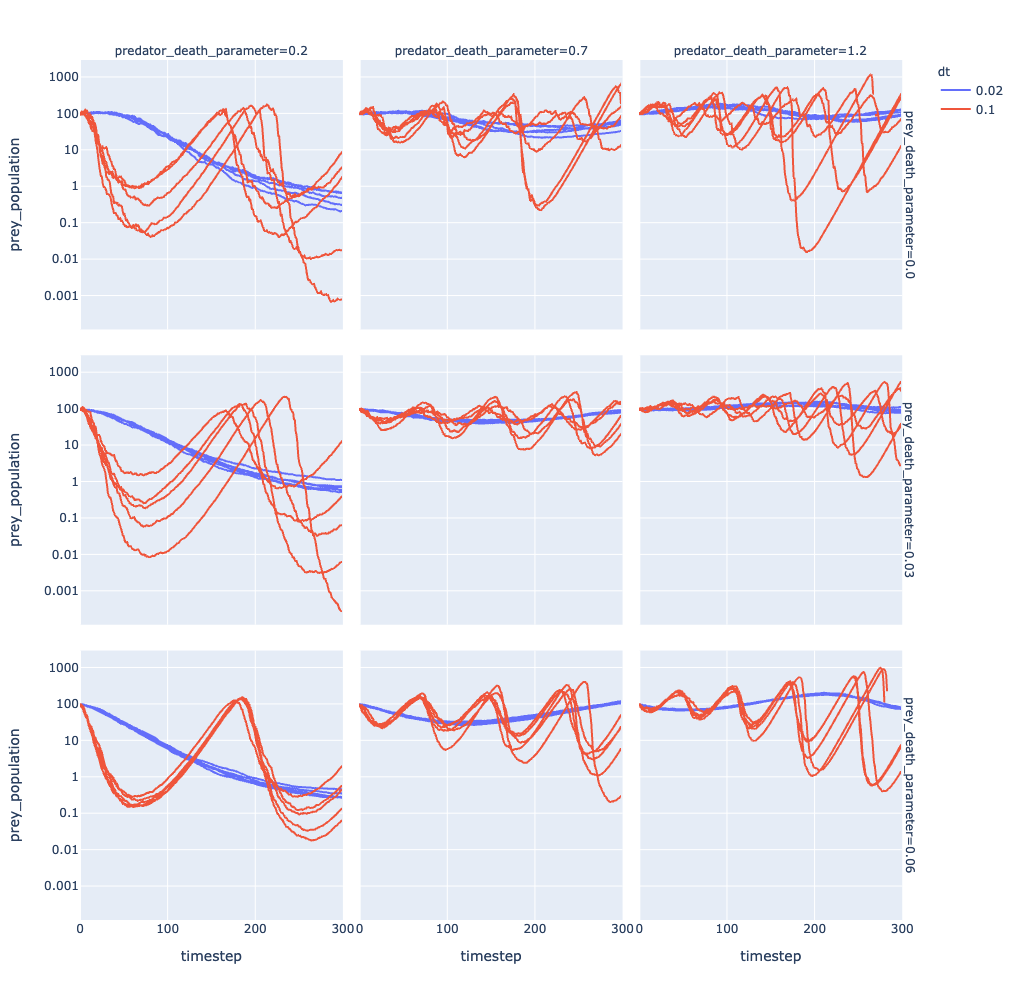

In [14]:
# Visualize how the predator and prey populations change over time

# Notice that the populations are more chaotic when the prey birth rate is higher,
# and the system is more stable when it is lower.

px.line(
    df,
    x='timestep', # Variable on the horizontal axis
    y='prey_population', # Variables on the vertical axis
    line_group='run', # One line for each MC run
    color='dt', # Color by `dt` sweep
    facet_row='prey_death_parameter', # Create a figure for each `prey_death_parameter` parameter sweep
    facet_col='predator_death_parameter', # Create a figure for each `predator_death_parameter` parameter sweep
    log_y=True, # Use log scale on the vertical axis,
    width=1000,
    height=1000
)

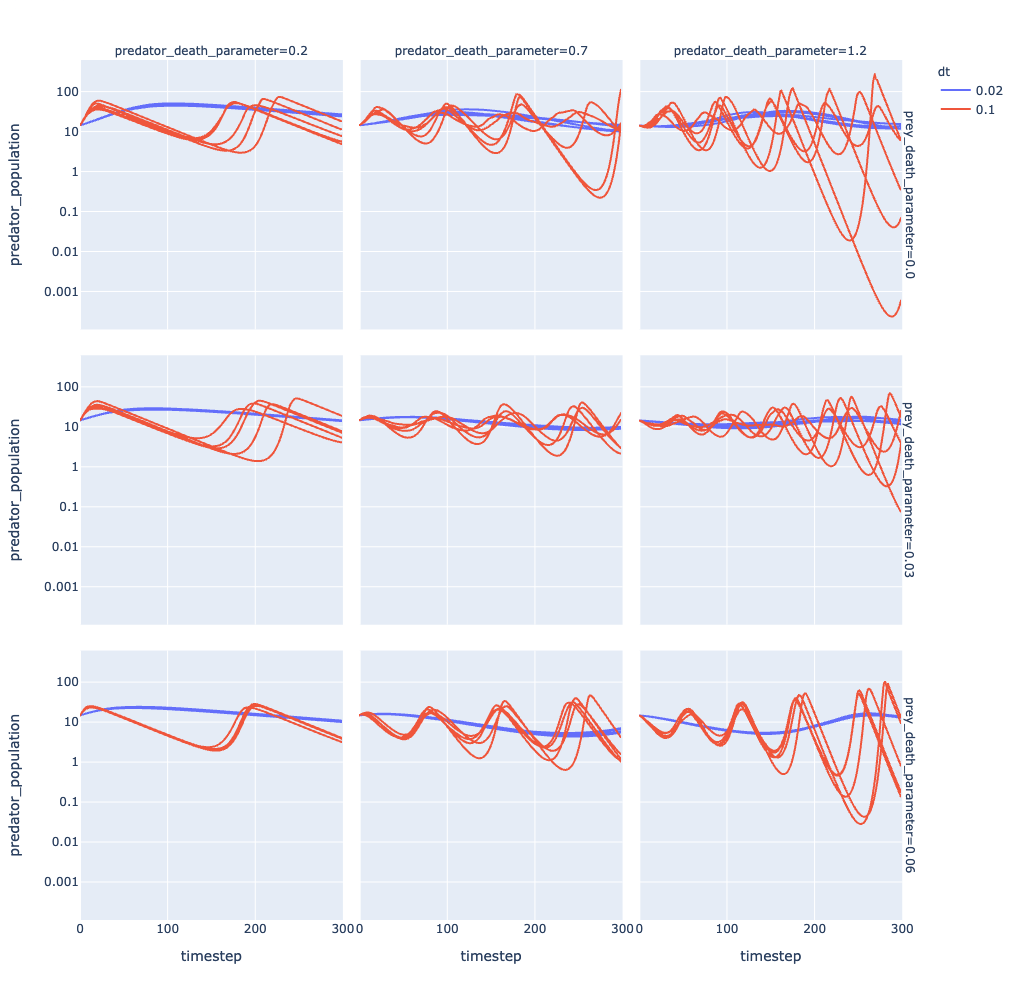

In [15]:
# Visualize how the predator and prey populations compare

# Notice that they tend to have cycles around a fixed point
# which means that their populations are never static,
# but rather cyclic with ups and downs.

px.line(
    df,
    x='timestep', # Variable on the horizontal axis
    y='predator_population', # Variables on the vertical axis
    line_group='run', # One line for each MC run
    color='dt', # Color by `dt` sweep
    facet_row='prey_death_parameter', # Create a figure for each `prey_death_parameter` parameter sweep
    facet_col='predator_death_parameter', # Create a figure for each `predator_death_parameter` parameter sweep
    log_y=True, # Use log scale on the vertical axis,
    width=1000,
    height=1000
)